### 🧠 Answer Synthesis from Multiple Sources
✅ What Is It?

Answer synthesis from multiple sources is the process where an AI agent collects information from different retrieval tools or knowledge bases, and merges that information into a single, coherent, and contextually rich answer.

This is a core capability in Agentic RAG, where the system is more than just a simple retriever — it plans, retrieves, and then synthesizes an answer that draws from multiple sources.



🎯 Why It’s Needed
Most real-world queries are:
- Multifaceted (require multiple types of information)
- Ambiguous or incomplete (need refinement)
- Open-ended (don’t map to a single document or source)

🔍 This makes retrieving from a single vector DB insufficient.

Instead, we want an agent that can:

- Decide what to fetch from where (retrieval planning)
- Retrieve content from multiple tools (e.g., Wikipedia, PDFs, APIs, SQL)
- Evaluate and merge that context
- Produce a single human-like response

In [8]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_classic.schema import Document
from langchain_classic.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders.youtube import YoutubeLoader
from langchain_community.document_loaders import ArxivLoader
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_classic.tools import WikipediaQueryRun
from langchain_classic.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END

In [9]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o-mini")

In [ ]:
def load_text_retriever(file_path):
    docs = TextLoader(file_path, encoding="utf-8").load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    return vs.as_retriever()

def load_youtube_retriever():
    # Mocked YouTube transcript text
    content = """
    This video explains how agentic AI systems rely on feedback loops, memory, and tool use.
    It compares them to traditional pipeline-based LLMs. Temporal reasoning and autonomous tasking are emphasized.
    """
    doc = Document(page_content=content, metadata={"source": "youtube"})
    vectorstore = FAISS.from_documents([doc], OpenAIEmbeddings())
    return vectorstore.as_retriever()



# def wikipedia_search(query: str) -> str:
#     print("🌐 Searching Wikipedia...")
#     return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())(query)

def arxiv_search(query: str) -> str:
    print("📄 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content for doc in results[:2]) or "No relevant papers found."

In [11]:
text_retriever = load_text_retriever("research_notes.txt")
youtube_retriever = load_youtube_retriever()

In [12]:
### state
class MultiSourceRAGState(BaseModel):
    question: str
    text_docs: List[Document] = []
    yt_docs: List[Document] = []
    wiki_context: str = ""
    arxiv_context: str = ""
    final_answer: str = ""

In [13]:
### Retrieval Nodes
def retrieve_text(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = text_retriever.invoke(state.question)
    return state.model_copy(update={"text_docs": docs})

def retrieve_yt(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = youtube_retriever.invoke(state.question)
    return state.model_copy(update={"yt_docs": docs})

def retrieve_wikipedia(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = wikipedia_search(state.question)
    return state.model_copy(update={"wiki_context": result})

def retrieve_arxiv(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = arxiv_search(state.question)
    return state.model_copy(update={"arxiv_context": result})

In [14]:
## synthesize
def synthesize_answer(state: MultiSourceRAGState) -> MultiSourceRAGState:
    
    context = ""

    context += "\n\n[Internal Docs]\n" + "\n".join([doc.page_content for doc in state.text_docs])
    context += "\n\n[YouTube Transcript]\n" + "\n".join([doc.page_content for doc in state.yt_docs])
    context += "\n\n[Wikipedia]\n" + state.wiki_context
    context += "\n\n[ArXiv]\n" + state.arxiv_context

    prompt = f"""You have retrieved relevant context from multiple sources. Now synthesize a complete and coherent answer.

Question: {state.question}

Context:
{context}

Final Answer:"""

    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"final_answer": answer})

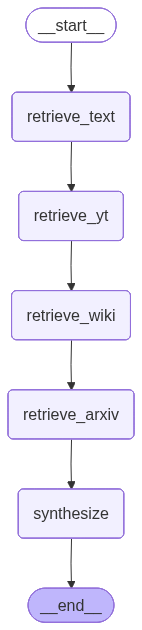

In [15]:
builder = StateGraph(MultiSourceRAGState)

builder.add_node("retrieve_text", retrieve_text)
builder.add_node("retrieve_yt", retrieve_yt)
builder.add_node("retrieve_wiki", retrieve_wikipedia)
builder.add_node("retrieve_arxiv", retrieve_arxiv)
builder.add_node("synthesize", synthesize_answer)

builder.set_entry_point("retrieve_text")
builder.add_edge("retrieve_text", "retrieve_yt")
builder.add_edge("retrieve_yt", "retrieve_wiki")
builder.add_edge("retrieve_wiki", "retrieve_arxiv")
builder.add_edge("retrieve_arxiv", "synthesize")
builder.add_edge("synthesize", END)

graph = builder.compile()
graph

In [17]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

def wikipedia_search(query: str) -> str:
    print("🌐 Searching Wikipedia...")

    wiki = WikipediaQueryRun(
        api_wrapper=WikipediaAPIWrapper()
    )

    return wiki.run(query)


In [18]:
question = "What are transformer agents and how are they evolving in recent research?"
state = MultiSourceRAGState(question=question)
result = graph.invoke(state)

print("✅ Final Answer:\n")
print(result["final_answer"])


🌐 Searching Wikipedia...
📄 Searching ArXiv...
✅ Final Answer:

Transformer agents represent a significant advancement in artificial intelligence, particularly in the field of multi-agent deep reinforcement learning (MADRL). These systems leverage the transformer architecture, which excels in understanding and processing complex data, to create autonomous agents capable of engaging in complex tasks within dynamic environments.

### What Are Transformer Agents?

Transformer agents are essentially AI agents that utilize the transformer neural network architecture to process information. They have been widely adopted for their ability to handle long-range dependencies in data and their parallel processing capabilities. These agents are often large language models (LLMs) capable of generating text, reasoning, and adapting their responses based on interactions with their environments and other agents.

**Key Characteristics of Transformer Agents:**

1. **Self-Attention Mechanism:** Unlike pr

In [19]:
result

{'question': 'What are transformer agents and how are they evolving in recent research?',
 'text_docs': [Document(id='b06ae613-a46e-4478-9d87-a6aca5a64f3e', metadata={'source': 'research_notes.txt'}, page_content='TinyBERT:\n- Used for classification: Support ticket priority tagging\n- Evaluation: 87% F1 score, confusion in ambiguous class C\n- Works well with 2-layer FFN adapter for domain transfer\n\nAdditional Experiments:\n\n1. FlashAttention2:\n   - Integrated into LLaMA2\n   - Reduces context latency by ~50%\n\n2. Chain-of-Thought prompting:\n   - Outperforms direct answer prompting by 8% on logic tasks\n   - Reflective prompting increases accuracy by 3%'),
  Document(id='6f6ca8ab-a2a0-496f-9130-9a0fc7211a29', metadata={'source': 'research_notes.txt'}, page_content='7. Safety:\n   - Toxicity detection via Detoxify\n   - Out-of-scope filter via zero-shot classifier\n   - Red teaming involved adversarial prompt testing\n\nConclusion:\n\n- LLaMA2 continues to be promising for contro